In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import cv2
import os
import random
import matplotlib.pyplot as plt 
import pickle 
from multiprocessing import Pool, Manager, cpu_count, Lock
import pickle
import keras  
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Activation,Dropout
import keras.losses
import time
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D, Dense

In [ ]:
!nvidia-smi

Tue Nov 23 03:53:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    885MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [134]:
from keras_preprocessing.image import ImageDataGenerator

In [135]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=[0.15,0.2],
        height_shift_range=[0.15,0.2],
        rescale=1./255,
        zoom_range=0.2,
        brightness_range=[0.5,1.5],
        fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

In [136]:
train_generator = train_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/datanew/train",target_size=(299,299),batch_size=32,shuffle=True)

Found 27279 images belonging to 7 classes.


In [137]:
val_generator = val_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/datanew/val",target_size=(299,299),batch_size=32,shuffle =True)

Found 3896 images belonging to 7 classes.


In [138]:
files_per_class = []
input_foldr = "/content/drive/MyDrive/Miczone/fingerprint/datanew/train"
for folder in os.listdir(input_foldr):
    if not os.path.isfile(folder):
            files_per_class.append(len(os.listdir(input_foldr + '/' + folder)))
total_files = sum(files_per_class)
class_weights = {}
print(files_per_class)
for i in range(len(files_per_class)):
    class_weights[i] = 1 - (float(files_per_class[i]) / total_files)

print(class_weights)

[2432, 6468, 6520, 4538, 4605, 267, 2449]
{0: 0.9108471718171487, 1: 0.7628945342571208, 2: 0.7609883060229481, 3: 0.8336449283331501, 4: 0.8311888265698889, 5: 0.9902122511822281, 6: 0.9102239818175153}


In [139]:
 train_generator.class_indices

{'ARCH': 0, 'RL': 1, 'UL': 2, 'WCDI': 3, 'WE': 4, 'WPL': 5, 'WST': 6}

In [140]:
for data_batch,label_batch in train_generator:
  print(data_batch.shape)
  print(label_batch.shape)
  break

(32, 299, 299, 3)
(32, 7)


In [141]:
baseModel = tf.keras.applications.Xception(include_top=False, weights="imagenet",input_shape=(299,299,3),classes=7)

In [142]:

baseModel.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [143]:
n_outputs= 7
fcHead = baseModel.output
# Output layer với softmax activation
# fcHead = Flatten()(fcHead)
fcHead = GlobalAveragePooling2D()(fcHead)
fcHead = Dense(512,activation="relu")(fcHead)
fcHead = Dense(n_outputs, activation='softmax')(fcHead)
model = tf.keras.Model(inputs=baseModel.input, outputs=fcHead)

In [144]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [145]:
for layer in baseModel.layers:
    layer.trainable =True

In [146]:
 model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Miczone/fingerprint/result/Xception299_version5.h5",
    monitor='val_loss',
    save_best_only=True)

In [147]:
csv_logger = keras.callbacks.CSVLogger("/content/drive/MyDrive/Miczone/fingerprint/result/Xception299_version5.csv",separator=',',append=True) 

In [149]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(amsgrad=True),
              metrics=['accuracy'])

In [150]:
history = model.fit_generator(train_generator,epochs=20, validation_data = val_generator,verbose = 1,callbacks=[model_checkpoint_callback,csv_logger])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
853/853 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.7560

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


853/853 [==============================] - 748s 869ms/step - loss: 0.6798 - accuracy: 0.7560 - val_loss: 0.5332 - val_accuracy: 0.8095
Epoch 2/20
853/853 [==============================] - 744s 872ms/step - loss: 0.5382 - accuracy: 0.8104 - val_loss: 0.4693 - val_accuracy: 0.8447
Epoch 3/20
853/853 [==============================] - 741s 868ms/step - loss: 0.4936 - accuracy: 0.8243 - val_loss: 0.4308 - val_accuracy: 0.8519
Epoch 4/20
853/853 [==============================] - 739s 865ms/step - loss: 0.4646 - accuracy: 0.8350 - val_loss: 0.4155 - val_accuracy: 0.8537
Epoch 5/20
853/853 [==============================] - 731s 856ms/step - loss: 0.4348 - accuracy: 0.8453 - val_loss: 0.4160 - val_accuracy: 0.8578
Epoch 6/20
853/853 [==============================] - 737s 863ms/step - loss: 0.4188 - accuracy: 0.8525 - val_loss: 0.4594 - val_accuracy: 0.8511
Epoch 7/20
853/853 [==============================] - 717s 840ms/step - loss: 0.4012 - accuracy: 0.8541 - val_loss: 0.3880 - val_accura

In [151]:
import pandas as pd

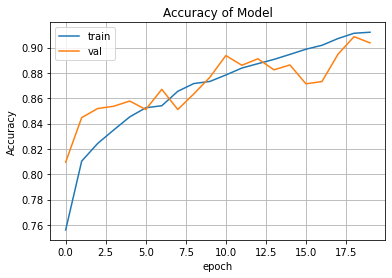

In [152]:
plt.title('Accuracy of Model')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

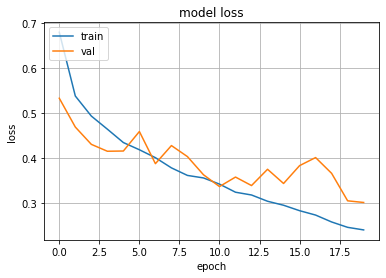

In [153]:
plt.title('Loss of Model')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/Miczone/fingerprint/result/Xception299_version4.h5')

In [154]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [155]:
test_generator = test_datagen.flow_from_directory(directory="/content/drive/MyDrive/Miczone/fingerprint/datanew/test",target_size=(299,299),batch_size=7795,class_mode="sparse",)

Found 7795 images belonging to 7 classes.


In [156]:
for Xtest,Ytest in test_generator:
  X_test = Xtest
  Y_test = Ytest
  break

In [157]:
Xtest.shape

(7795, 299, 299, 3)

In [158]:
pred = model.predict(X_test)

In [159]:
pred_idx = np.argmax(pred, axis=1)

In [160]:
print(classification_report(Y_test, pred_idx))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       695
         1.0       0.97      0.97      0.97      1848
         2.0       0.98      0.97      0.97      1863
         3.0       0.89      0.84      0.87      1297
         4.0       0.80      0.88      0.84      1316
         5.0       0.68      0.59      0.63        76
         6.0       0.80      0.78      0.79       700

    accuracy                           0.91      7795
   macro avg       0.87      0.86      0.86      7795
weighted avg       0.91      0.91      0.91      7795



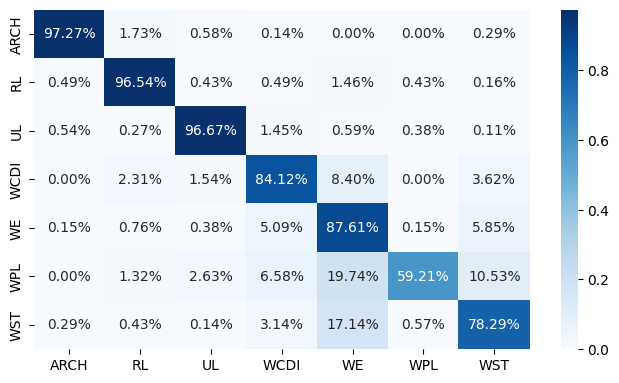

In [161]:
 import pandas as pd
import seaborn as sns
cm = confusion_matrix(Y_test,pred_idx)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmn, index=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"], columns=['ARCH', 'RL','UL','WCDI','WE',"WPL","WST"])
plt.figure(figsize = (8,4.5),dpi=100)
sns.heatmap(df_cm, cmap="Blues", annot=True,fmt='.2%')
plt.show()

In [ ]:
y